# Douban Top250 — 导演-演员二部图与演员-演员网络（含评分分布聚类）

说明：此 notebook 基于你提供的 details_info.csv（sproutiiing/Douban-top250）。
功能要点：
- 支持每部电影仅保留前 K 位演员（actor limit）用于网络构建（默认 K=4），以减少群演噪声；也保留完整演员列表供对照。
- 构建演员-演员共现网络（基于限额演员）并导出 top 子图和交互 HTML（若安装 pyvis）。
- 构建导演-演员二部图（bipartite graph），计算二部度中心度并导出投影（director-director、actor-actor）。
- 使用五星..一星比例进行聚类（KMeans + silhouette 选 k），并用 PCA 可视化簇分布。
- 将结果保存到 douban_outputs/ 目录（CSV/PNG/HTML/JSON）。

在运行之前，建议在具有必要库的环境中运行（pandas, numpy, matplotlib, seaborn, scikit-learn, networkx）。
可选安装：python-louvain（社区检测），pyvis（交互式网络 HTML）。


In [1]:
# 如果你需要在 notebook 中安装依赖，请取消下面一行的注释并运行（在 Colab 中可能需要）
#!pip install pandas numpy matplotlib seaborn scikit-learn networkx python-louvain pyvis
print('如果需要安装依赖，请取消上面 pip 行的注释并运行。')

如果需要安装依赖，请取消上面 pip 行的注释并运行。


In [2]:
import os
# 把线程数都限定为 1，尽量覆盖常见实现
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

import re
import json
from itertools import combinations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import plotly.graph_objects as go
from plotly.offline import plot

from networkx.algorithms import bipartite
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

try:
    import community as community_louvain
except Exception:
    community_louvain = None

try:
    from pyvis.network import Network
except Exception:
    Network = None

RANDOM_STATE = 42
OUTPUT_DIR = 'D:\Jupyter_Python\分布式基础作业\豆瓣top250数据分析\output'
os.makedirs(OUTPUT_DIR, exist_ok=True)
TOP_N = 20
ACTOR_LIMIT_PER_MOVIE = 4  # 默认仅保留每部电影前4位演员用于网络构建，<=0 则保留全部
K_RANGE = range(2,7)
sns.set(style='whitegrid')
print('环境就绪')

环境就绪


## Helper（读取/解析/百分比转换/截断演员列表）

In [3]:
SPLIT_RE = re.compile(r'\s*[，,、/;]\s*')
def read_csv_robust(path):
    df = pd.read_csv(path, encoding='utf-8-sig', low_memory=False, quotechar='"')
    df.columns = df.columns.astype(str).str.strip().str.replace('\ufeff', '', regex=False)
    return df

def split_names(cell):
    if pd.isna(cell):
        return []
    s = str(cell).strip()
    parts = [p.strip() for p in SPLIT_RE.split(s) if p.strip()]
    clean = []
    for p in parts:
        p = re.sub(r'\s*\.{2,}.*$', '', p)
        p = re.sub(r'[\[\(].*?[\]\)]', '', p)
        p = p.strip()
        if p:
            clean.append(p)
    return clean

def to_percent_float(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (float, int, np.floating, np.integer)):
        v = float(x)
        return v/100.0 if v>1 else v
    s = str(x).strip()
    if s.endswith('%'):
        try:
            return float(s.rstrip('%'))/100.0
        except:
            return np.nan
    try:
        v = float(s)
        return v/100.0 if v>1 else v
    except:
        m = re.search(r'[\d\.]+', s)
        if m:
            v = float(m.group())
            return v/100.0 if v>1 else v
        return np.nan

def limit_actors_list(actor_list, k):
    if k is None or k <= 0:
        return actor_list
    return actor_list[:k]

print('helpers defined')

helpers defined


## 读取 CSV（请确保 details_info.csv 在当前目录）

In [4]:
CSV_PATH = 'details_info.csv'
df = read_csv_robust(CSV_PATH)
print('rows, cols =', df.shape)
df.columns[:60]


rows, cols = (250, 23)


Index(['排名', '电影名', '导演', '编剧', '主演', '类型', '制片国家或地区', '语言', '年份', '上映日期',
       '片长', '又名', 'IMDb', '评分', '评分人数', '五星比例', '四星比例', '三星比例', '二星比例',
       '一星比例', '简介', '海报', '链接'],
      dtype='object')

## 自动映射常用列并数值化评分、票数、星级比例

In [5]:
def find_col(df, starts):
    for c in df.columns:
        for s in starts:
            if c.strip().startswith(s):
                return c
    return None

col_director = find_col(df, ['导演'])
col_actor = find_col(df, ['主演'])
col_rating = find_col(df, ['评分'])
col_votes = find_col(df, ['评分人数'])
col_s5 = find_col(df, ['五星比例'])
col_s4 = find_col(df, ['四星比例'])
col_s3 = find_col(df, ['三星比例'])
col_s2 = find_col(df, ['二星比例'])
col_s1 = find_col(df, ['一星比例'])

print('mapped columns:')
print(' director:', col_director)
print(' actor:', col_actor)
print(' rating:', col_rating, ' votes:', col_votes)
print(' stars:', col_s5, col_s4, col_s3, col_s2, col_s1)

df['rating'] = pd.to_numeric(df[col_rating], errors='coerce') if col_rating else np.nan
df['rating_count'] = pd.to_numeric(df[col_votes].astype(str).str.replace(',', ''), errors='coerce') if col_votes else np.nan
for name, col in [('s5', col_s5), ('s4', col_s4), ('s3', col_s3), ('s2', col_s2), ('s1', col_s1)]:
    df[name] = df[col].apply(to_percent_float) if col else np.nan

df['avg_from_stars'] = (5*df['s5'] + 4*df['s4'] + 3*df['s3'] + 2*df['s2'] + 1*df['s1']) / df[['s5','s4','s3','s2','s1']].sum(axis=1)

df[['排名','电影名','rating','rating_count','s5','s4','s3','s2','s1','avg_from_stars']].head()


mapped columns:
 director: 导演
 actor: 主演
 rating: 评分  votes: 评分人数
 stars: 五星比例 四星比例 三星比例 二星比例 一星比例


,排名,电影名,rating,rating_count,s5,s4,s3,s2,s1,avg_from_stars
0,1,肖申克的救赎 The Shawshank Redemption,9.7,3226978,0.857,0.128,0.013,0.001,0.001,4.839000
1,2,霸王别姬,9.6,2381885,0.825,0.152,0.020,0.002,0.002,4.794206
2,3,泰坦尼克号 Titanic,9.5,2451058,0.769,0.199,0.029,0.002,0.001,4.733000
3,4,阿甘正传 Forrest Gump,9.5,2391986,0.769,0.199,0.028,0.002,0.001,4.734735
4,5,千与千寻 千と千尋の神隠し,9.4,2491688,0.736,0.227,0.033,0.002,0.001,4.696697


## 解析导演/主演列表并按 actor limit 创建两个演员列表（全部 & 限制版）

In [6]:
df['directors_list'] = df[col_director].fillna('').apply(split_names) if col_director else [[]]*len(df)
df['actors_list_full'] = df[col_actor].fillna('').apply(split_names) if col_actor else [[]]*len(df)
df['actors_list'] = df['actors_list_full'].apply(lambda L: limit_actors_list(L, ACTOR_LIMIT_PER_MOVIE))

print('sample parsed movie ->', df[['排名','电影名','directors_list','actors_list']].head(3).to_dict(orient='records'))


sample parsed movie -> [{'排名': 1, '电影名': '肖申克的救赎 The Shawshank Redemption', 'directors_list': ['弗兰克·德拉邦特'], 'actors_list': ['蒂姆·罗宾斯', '摩根·弗里曼', '鲍勃·冈顿', '威廉·赛德勒']}, {'排名': 2, '电影名': '霸王别姬', 'directors_list': ['陈凯歌'], 'actors_list': ['张国荣', '张丰毅', '巩俐', '葛优']}, {'排名': 3, '电影名': '泰坦尼克号 Titanic', 'directors_list': ['詹姆斯·卡梅隆'], 'actors_list': ['莱昂纳多·迪卡普里奥', '凯特·温斯莱特', '比利·赞恩', '凯西·贝茨']}]


## Top 导演 / Top 演员（统计：出现次数、平均评分、平均票数）

In [7]:
dirs_exploded = df.explode('directors_list').dropna(subset=['directors_list'])
dirs_exploded = dirs_exploded[dirs_exploded['directors_list']!='']
dir_stats = dirs_exploded.groupby('directors_list').agg(
    count=('电影名','count'),
    mean_rating=('rating','mean'),
    median_rating=('rating','median'),
    mean_votes=('rating_count','mean')
).reset_index().rename(columns={'directors_list':'director'}).sort_values('count', ascending=False)

actors_exploded = df.explode('actors_list').dropna(subset=['actors_list'])
actors_exploded = actors_exploded[actors_exploded['actors_list']!='']
actor_stats = actors_exploded.groupby('actors_list').agg(
    count=('电影名','count'),
    mean_rating=('rating','mean'),
    mean_votes=('rating_count','mean')
).reset_index().rename(columns={'actors_list':'actor'}).sort_values('count', ascending=False)

actors_full_exploded = df.explode('actors_list_full').dropna(subset=['actors_list_full'])
actors_full_exploded = actors_full_exploded[actors_full_exploded['actors_list_full']!='']
actor_stats_full = actors_full_exploded.groupby('actors_list_full').agg(
    count=('电影名','count'),
    mean_rating=('rating','mean'),
    mean_votes=('rating_count','mean')
).reset_index().rename(columns={'actors_list_full':'actor'}).sort_values('count', ascending=False)

dir_stats.head(TOP_N).to_csv(os.path.join(OUTPUT_DIR,'top_directors.csv'), index=False)
actor_stats_full.head(TOP_N).to_csv(os.path.join(OUTPUT_DIR,'top_actors_full.csv'), index=False)
actor_stats.head(TOP_N).to_csv(os.path.join(OUTPUT_DIR,'top_actors_limited.csv'), index=False)

print('Top lists saved to', OUTPUT_DIR)
dir_stats.head(10)


Top lists saved to D:\Jupyter_Python\分布式基础作业\豆瓣top250数据分析\output


,director,count,mean_rating,median_rating,mean_votes
57,宫崎骏,8,9.000000,9.00,1.034031e+06
33,史蒂文·斯皮尔伯格,6,8.966667,8.95,9.592537e+05
23,克里斯托弗·诺兰,6,9.083333,9.05,1.334595e+06
101,李安,5,8.960000,9.00,8.639866e+05
11,今敏,4,8.975000,9.00,3.924148e+05
73,彼特·道格特,4,8.850000,8.80,1.034850e+06
92,是枝裕和,4,8.850000,8.80,5.219412e+05
124,王家卫,4,8.800000,8.80,7.577482e+05
43,大卫·芬奇,4,8.875000,8.90,1.037152e+06
99,李·昂克里奇,3,8.933333,8.90,1.092465e+06


## 演员-演员共现网络（基于限额演员列表），并导出 top 子图（静态 & 可选交互）

actor graph nodes, edges = 801 1430


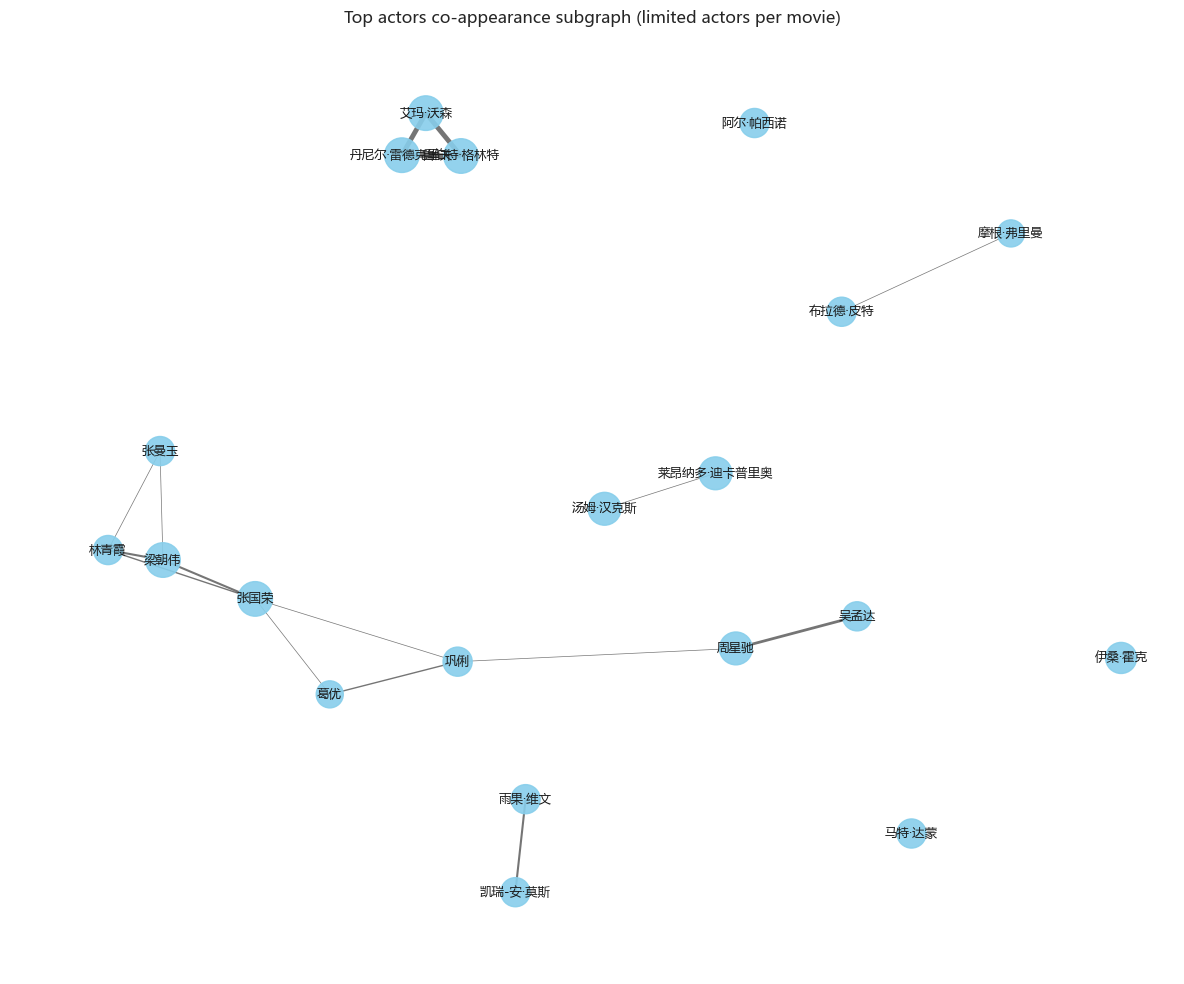

Saved interactive network to D:\Jupyter_Python\分布式基础作业\豆瓣top250数据分析\output\actor_network_plotly.html
Actor interactive saved to D:\Jupyter_Python\分布式基础作业\豆瓣top250数据分析\output\actor_network_top_limited.html


In [8]:


G_actor = nx.Graph()
for idx, row in df.iterrows():
    actors = [a for a in row['actors_list'] if a]
    if len(actors) < 2:
        continue
    for a1,a2 in combinations(sorted(set(actors)), 2):
        if G_actor.has_edge(a1,a2):
            G_actor[a1][a2]['weight'] += 1
        else:
            G_actor.add_edge(a1,a2, weight=1)

print('actor graph nodes, edges =', G_actor.number_of_nodes(), G_actor.number_of_edges())
weighted_deg_actor = {n: sum(d.get('weight',1) for _,_,d in G_actor.edges(n, data=True)) for n in G_actor.nodes()}
nx.set_node_attributes(G_actor, weighted_deg_actor, 'weighted_degree')
top_actor_by_deg = sorted(weighted_deg_actor.items(), key=lambda x: x[1], reverse=True)[:TOP_N]
pd.DataFrame(top_actor_by_deg, columns=['actor','weighted_degree']).to_csv(os.path.join(OUTPUT_DIR,'top_actors_by_weighted_degree.csv'), index=False)


plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']   # 或 ['SimHei']
plt.rcParams['font.family'] = 'sans-serif'
# 避免负号 '-' 显示为方块
plt.rcParams['axes.unicode_minus'] = False

top_nodes = [n for n,_ in top_actor_by_deg]
subG_actor = G_actor.subgraph(top_nodes).copy()
plt.figure(figsize=(12,10))
pos = nx.spring_layout(subG_actor, seed=RANDOM_STATE, k=0.6)
node_sizes = [200 + subG_actor.nodes[n].get('weighted_degree',0)*20 for n in subG_actor.nodes()]
nx.draw_networkx_nodes(subG_actor, pos, node_size=node_sizes, node_color='skyblue', alpha=0.9)
nx.draw_networkx_edges(subG_actor, pos, width=[max(0.5, subG_actor[u][v]['weight']*0.5) for u,v in subG_actor.edges()], alpha=0.6)
nx.draw_networkx_labels(subG_actor, pos, font_size=9)
plt.title('Top actors co-appearance subgraph (limited actors per movie)')
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR,'actor_subgraph_top_limited.png'), dpi=150)
plt.show()

if Network is not None:
    net = Network(height='800px', width='100%', bgcolor='#ffffff', font_color='black', notebook=False)
    net.force_atlas_2based()
    for n,d in subG_actor.nodes(data=True):
        size = 10 + (d.get('weighted_degree') or 0) * 2
        title = f"{n}<br>weighted_degree: {d.get('weighted_degree')}"
        net.add_node(n, label=n, title=title, value=size)
    for u,v,data in subG_actor.edges(data=True):
        net.add_edge(u, v, value=data.get('weight',1))
    actor_html = os.path.join(OUTPUT_DIR, 'actor_network_top_limited.html')

    def save_network_plotly(G, path_html, title="Network", node_label_attr=None):
        # compute layout (deterministic via seed)
        pos = nx.spring_layout(G, seed=42, k=0.6)
    
        # edges for plotting
        edge_x = []
        edge_y = []
        for u, v, data in G.edges(data=True):
            x0, y0 = pos[u]
            x1, y1 = pos[v]
            edge_x += [x0, x1, None]
            edge_y += [y0, y1, None]
    
        edge_trace = go.Scatter(
            x=edge_x, y=edge_y,
            line=dict(width=0.6, color='#888'),
            hoverinfo='none',
            mode='lines'
        )
    
        # nodes
        node_x, node_y, node_text, node_color, node_size = [], [], [], [], []
        for n, data in G.nodes(data=True):
            x, y = pos[n]
            node_x.append(x); node_y.append(y)
            wd = data.get('weighted_degree', 0)
            deg = G.degree(n)
            label = n
            if node_label_attr and node_label_attr in data:
                label = f"{n} ({data.get(node_label_attr)})"
            node_text.append(f"{n}<br>degree:{deg}<br>weighted_degree:{wd}")
            node_color.append(wd)
            node_size.append(10 + wd * 2)
    
        node_trace = go.Scatter(
            x=node_x, y=node_y,
            mode='markers+text',
            hoverinfo='text',
            textposition='top center',
            marker=dict(
                showscale=True,
                colorscale='YlGnBu',
                color=node_color,
                size=node_size,
                colorbar=dict(thickness=12, title='weighted_degree'),
                line_width=1
            ),
            text=[n for n,_ in G.nodes(data=True)],
            hovertext=node_text
        )
    
        fig = go.Figure(data=[edge_trace, node_trace],
                        layout=go.Layout(
                            title=title,
                            titlefont_size=16,
                            showlegend=False,
                            hovermode='closest',
                            margin=dict(b=20,l=5,r=5,t=40),
                            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                        ))
        plot(fig, filename=path_html, auto_open=False, include_plotlyjs='cdn')
        print("Saved interactive network to", path_html)
    
    # 使用示例（假设 subG_actor 是你之前生成的 networkx 子图）
    save_network_plotly(subG_actor, os.path.join(OUTPUT_DIR, 'actor_network_plotly.html'), title="Actor network (Plotly)")
    # 若要对二部图子图可视化，也可调用： save_network_plotly(subB, 'path.html')
    
    print('Actor interactive saved to', actor_html)
else:
    print('pyvis not installed: interactive actor network not generated')


## 导演-演员二部图（bipartite graph）：构建、导出节点/边、计算二部度中心度与投影

In [9]:
B = nx.Graph()
for _, row in df.iterrows():
    directors = [d for d in row['directors_list'] if d]
    actors = [a for a in row['actors_list'] if a]
    if not directors or not actors:
        continue
    for d in directors:
        B.add_node(d, bipartite='director')
        for a in actors:
            B.add_node(a, bipartite='actor')
            if B.has_edge(d, a):
                B[d][a]['weight'] += 1
            else:
                B.add_edge(d, a, weight=1)

print('B bipartite nodes, edges =', B.number_of_nodes(), B.number_of_edges())

nodes_data = []
for n, attrs in B.nodes(data=True):
    nodes_data.append({'name': n, 'bipartite': attrs.get('bipartite'), 'weighted_degree': sum(d.get('weight',1) for _,_,d in B.edges(n, data=True))})
pd.DataFrame(nodes_data).to_csv(os.path.join(OUTPUT_DIR,'bipartite_nodes.csv'), index=False)
edges_data = []
for u,v,d in B.edges(data=True):
    edges_data.append({'u': u, 'v': v, 'weight': d.get('weight',1)})
pd.DataFrame(edges_data).to_csv(os.path.join(OUTPUT_DIR,'bipartite_edges.csv'), index=False)

director_nodes = [n for n,d in B.nodes(data=True) if d.get('bipartite')=='director']
actor_nodes = [n for n,d in B.nodes(data=True) if d.get('bipartite')=='actor']
deg_centrality = bipartite.degree_centrality(B, director_nodes)
director_dc = {n: deg_centrality[n] for n in director_nodes}
actor_dc = {n: deg_centrality[n] for n in actor_nodes}
pd.DataFrame(sorted(director_dc.items(), key=lambda x: x[1], reverse=True)[:TOP_N], columns=['director','bipartite_degree']).to_csv(os.path.join(OUTPUT_DIR,'top_directors_bipartite_degree.csv'), index=False)
pd.DataFrame(sorted(actor_dc.items(), key=lambda x: x[1], reverse=True)[:TOP_N], columns=['actor','bipartite_degree']).to_csv(os.path.join(OUTPUT_DIR,'top_actors_bipartite_degree.csv'), index=False)

print('Saved bipartite nodes/edges and bipartite degree top lists.')

try:
    director_proj = bipartite.weighted_projected_graph(B, director_nodes)
    dir_proj_wdeg = {n: sum(d.get('weight',1) for _,_,d in director_proj.edges(n, data=True)) for n in director_proj.nodes()}
    pd.DataFrame(sorted(dir_proj_wdeg.items(), key=lambda x: x[1], reverse=True)[:TOP_N], columns=['director','proj_weighted_degree']).to_csv(os.path.join(OUTPUT_DIR,'director_projection_top.csv'), index=False)
    print('Director projection saved')
except Exception as e:
    print('Director projection failed:', e)

try:
    actor_proj_from_director = bipartite.weighted_projected_graph(B, actor_nodes)
    actor_proj_wdeg = {n: sum(d.get('weight',1) for _,_,d in actor_proj_from_director.edges(n, data=True)) for n in actor_proj_from_director.nodes()}
    pd.DataFrame(sorted(actor_proj_wdeg.items(), key=lambda x: x[1], reverse=True)[:TOP_N], columns=['actor','proj_weighted_degree']).to_csv(os.path.join(OUTPUT_DIR,'actor_projection_top.csv'), index=False)
    print('Actor projection saved')
except Exception as e:
    print('Actor projection failed:', e)

bip_meta = {'n_nodes': B.number_of_nodes(), 'n_edges': B.number_of_edges(), 'n_directors': len(director_nodes), 'n_actors': len(actor_nodes), 'actor_limit_per_movie': ACTOR_LIMIT_PER_MOVIE}
with open(os.path.join(OUTPUT_DIR,'bipartite_summary.json'),'w', encoding='utf-8') as f:
    json.dump(bip_meta, f, ensure_ascii=False, indent=2)

if Network is not None:
    print('Generating interactive bipartite subset via pyvis...')
    # choose top directors by projection if available else first directors
    try:
        top_dir_proj = pd.read_csv(os.path.join(OUTPUT_DIR,'director_projection_top.csv'))['director'].tolist()
    except Exception:
        top_dir_proj = director_nodes[:40]
    M = 40
    top_dirs_names = top_dir_proj[:M]
    viz_nodes = set(top_dirs_names)
    for d in top_dirs_names:
        viz_nodes.update(n for n in B.neighbors(d))
    subB = B.subgraph(viz_nodes).copy()
    net = Network(height='900px', width='100%', bgcolor='#ffffff', font_color='black', notebook=False)
    net.force_atlas_2based()
    for n,attrs in subB.nodes(data=True):
        role = attrs.get('bipartite')
        size = 15 if role=='director' else 8
        color = '#ffcc00' if role=='director' else '#66ccff'
        title = f"{n} ({role})"
        net.add_node(n, label=n, title=title, value=size, color=color)
    for u,v,data in subB.edges(data=True):
        net.add_edge(u, v, value=data.get('weight',1))
    bip_html = os.path.join(OUTPUT_DIR, 'director_actor_bipartite.html')

    def save_bipartite_plotly(B_sub, path_html, title="Bipartite subgraph", use_scattergl=False):
        # B_sub: networkx Graph where node attribute 'bipartite' == 'director' or 'actor'
        pos = nx.spring_layout(B_sub, seed=42, k=0.6)
        edge_x, edge_y = [], []
        for u, v, data in B_sub.edges(data=True):
            x0, y0 = pos[u]; x1, y1 = pos[v]
            edge_x += [x0, x1, None]; edge_y += [y0, y1, None]
        edge_trace = go.Scatter(x=edge_x, y=edge_y, line=dict(width=0.6, color='#888'), hoverinfo='none', mode='lines')
    
        node_x, node_y, node_text, node_color, node_size = [], [], [], [], []
        for n, data in B_sub.nodes(data=True):
            x,y = pos[n]
            node_x.append(x); node_y.append(y)
            role = data.get('bipartite', '')
            wd = data.get('weighted_degree', 0)
            node_text.append(f"{n} ({role})<br>weighted_degree:{wd}")
            # directors in one color, actors in another
            node_color.append(1 if role=='director' else 0)
            node_size.append(14 if role=='director' else 8 + wd*1.5)
    
        ScatterClass = go.Scattergl if use_scattergl else go.Scatter
        node_trace = ScatterClass(x=node_x, y=node_y, mode='markers+text', hoverinfo='text',
                                  text=[n for n,_ in B_sub.nodes(data=True)],
                                  hovertext=node_text,
                                  marker=dict(colorscale='Portland', color=node_color, size=node_size,
                                              colorbar=dict(title='role (1=director)')))
    
        fig = go.Figure(data=[edge_trace, node_trace],
                        layout=go.Layout(title=title, showlegend=False,
                                         xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                                         yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))
        plot(fig, filename=path_html, auto_open=False, include_plotlyjs='cdn')
        print("Saved bipartite interactive to", path_html)
    
    # 调用例子（假设 subB 为你准备好的 bipartite 子图）
    save_bipartite_plotly(subB, os.path.join(OUTPUT_DIR, 'bipartite_plotly.html'))
    
    print('Saved bipartite interactive to', bip_html)
else:
    print('pyvis not installed — skip bipartite interactive visualization')


B bipartite nodes, edges = 987 1057
Saved bipartite nodes/edges and bipartite degree top lists.
Director projection saved
Actor projection saved
Generating interactive bipartite subset via pyvis...
Saved bipartite interactive to D:\Jupyter_Python\分布式基础作业\豆瓣top250数据分析\output\bipartite_plotly.html
Saved bipartite interactive to D:\Jupyter_Python\分布式基础作业\豆瓣top250数据分析\output\director_actor_bipartite.html


## 基于五星..一星比例的聚类（评分分布类型）并可视化（PCA）

silhouette scores: {2: 0.4395513475307599, 3: 0.4403995071074855, 4: 0.35056694279795775, 5: 0.35662145654421795, 6: 0.31455014264500014}
selected k= 3


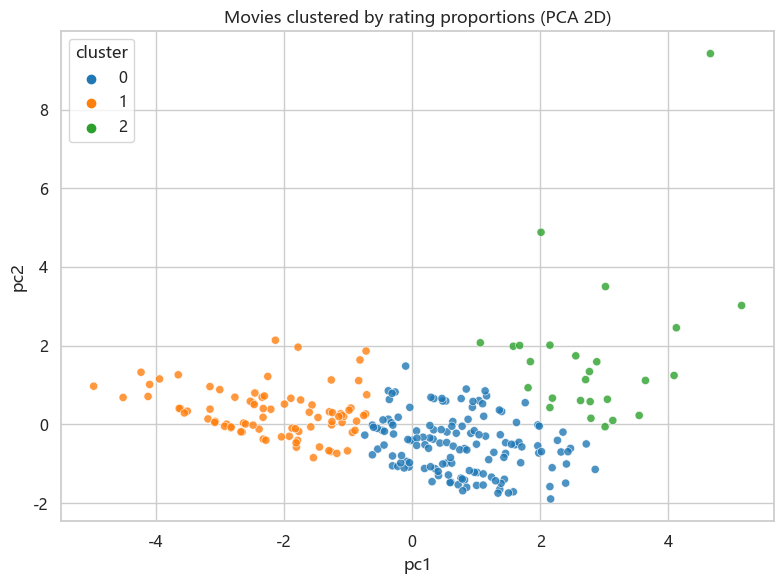

Clustering outputs saved to D:\Jupyter_Python\分布式基础作业\豆瓣top250数据分析\output


In [10]:
prop_cols = ['s5','s4','s3','s2','s1']
X_raw = df[prop_cols].fillna(0).values
sums = X_raw.sum(axis=1, keepdims=True)
sums[sums==0] = 1.0
X_norm = X_raw / sums
scaler = StandardScaler()
Xs = scaler.fit_transform(X_norm)

best_k = None
best_score = -1
best_model = None
scores = {}
for k in K_RANGE:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = km.fit_predict(Xs)
    try:
        score = silhouette_score(Xs, labels)
    except Exception:
        score = -1
    scores[k] = score
    if score > best_score:
        best_score = score
        best_k = k
        best_model = km

print('silhouette scores:', scores)
print('selected k=', best_k)

df['rating_cluster'] = best_model.predict(Xs)
centers = scaler.inverse_transform(best_model.cluster_centers_)
centers = (centers.T / centers.sum(axis=1)).T
centers_df = pd.DataFrame(centers, columns=prop_cols)
centers_df.to_csv(os.path.join(OUTPUT_DIR,'cluster_centers_proportions.csv'), index_label='cluster')

pca = PCA(n_components=2, random_state=RANDOM_STATE)
proj = pca.fit_transform(Xs)
df['pc1'] = proj[:,0]; df['pc2'] = proj[:,1]
plt.figure(figsize=(8,6))
sns.scatterplot(x='pc1', y='pc2', hue='rating_cluster', palette='tab10', data=df, s=35, alpha=0.8)
plt.title('Movies clustered by rating proportions (PCA 2D)')
plt.legend(title='cluster')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR,'rating_clusters_pca.png'), dpi=150)
plt.show()

cluster_summary = df.groupby('rating_cluster').agg(n_movies=('电影名','count'), mean_rating=('rating','mean'), median_rating=('rating','median'), mean_votes=('rating_count','mean')).reset_index()
cluster_summary.to_csv(os.path.join(OUTPUT_DIR,'rating_cluster_summary.csv'), index=False)
for k in sorted(df['rating_cluster'].unique()):
    ex = df[df['rating_cluster']==k].sort_values('rating', ascending=False)[['排名','电影名','rating','rating_count']].head(10)
    ex.to_csv(os.path.join(OUTPUT_DIR, f'cluster_{k}_top_examples.csv'), index=False)
print('Clustering outputs saved to', OUTPUT_DIR)


## 五星比例 vs 平均分（相关性）

Pearson (s5, rating): PearsonRResult(statistic=0.9842170912870636, pvalue=1.5395081546583835e-188)
Spearman (s5, rating): SignificanceResult(statistic=0.981633762997846, pvalue=1.9127796626994291e-180)


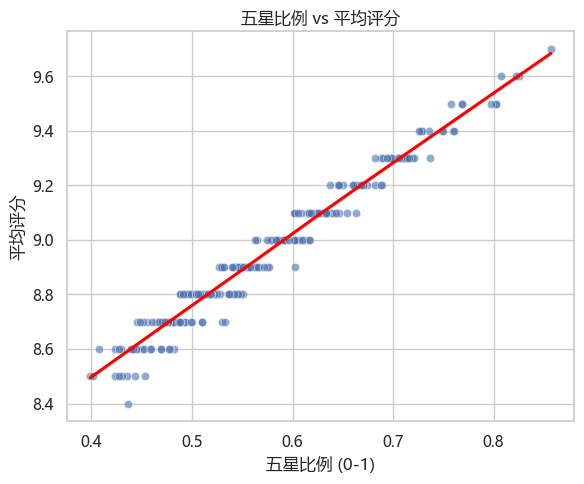

In [11]:
import scipy.stats as stats
valid = df[~df['s5'].isna() & ~df['rating'].isna()]
pearson_r = stats.pearsonr(valid['s5'], valid['rating'])
spearman_r = stats.spearmanr(valid['s5'], valid['rating'])
print('Pearson (s5, rating):', pearson_r)
print('Spearman (s5, rating):', spearman_r)

plt.figure(figsize=(6,5))
sns.scatterplot(x='s5', y='rating', data=df, alpha=0.6)
sns.regplot(x='s5', y='rating', data=df, scatter=False, lowess=True, color='red')
plt.xlabel('五星比例 (0-1)')
plt.ylabel('平均评分')
plt.title('五星比例 vs 平均评分')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR,'s5_vs_rating.png'), dpi=150)
plt.show()


## 保存带簇标注的电影表与总结

In [12]:
out_cols = ['排名','电影名','directors_list','actors_list_full','rating','rating_count','s5','s4','s3','s2','s1','avg_from_stars','rating_cluster']
exist_cols = [c for c in out_cols if c in df.columns]
df[exist_cols].to_csv(os.path.join(OUTPUT_DIR,'movies_with_clusters.csv'), index=False)
print('Saved movies_with_clusters.csv and other outputs to', OUTPUT_DIR)


Saved movies_with_clusters.csv and other outputs to D:\Jupyter_Python\分布式基础作业\豆瓣top250数据分析\output


## 小结

- 已把脚本完整迁移为 Notebook，包含可配置的 ACTOR_LIMIT_PER_MOVIE（默认 4）以及导演-演员二部图分析和投影。
- 输出位于 douban_outputs/，运行后检查 CSV/PNG/HTML 即可。

接下来我可以：
- 在两种设置下（ACTOR_LIMIT_PER_MOVIE=4 vs 全员）运行并对比网络统计（度分布、连通组件、聚类系数）；
- 把 Notebook 转为仓库文件并帮你创建 PR（如果你希望我提交到仓库）。
